# Sentiment Analysis on The Reddit Climate Change Dataset
by Santiago Segovia

### Motivation

We will use the Reddit Climate Change Dataset to fine-tune a DistilBERT model that is able to classify whether a comment in Reddit towards climate change is positive or negative. The analysis follows [this publication](https://huggingface.co/blog/sentiment-analysis-python) from Hugginface.

The first pre-trained model we use is `distilbert-base-uncased`. We'll use this results as a baseline

### 1. Install Dependencies and Initial Setup

In [1]:
!pip install datasets transformers accelerate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import torch

from google.colab import drive
from transformers import pipeline

In [3]:
USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
    DEVICE = torch.device('cuda')
    train_obs = 10000
    test_obs = 1000
    print("Using cuda.")
else:
    DEVICE = torch.device('cpu')
    train_obs = 3000
    test_obs = 300
    print("Using cpu.")

Using cpu.


In [4]:
# Mount GDrive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
# Load data (takes ~1 min to load)
import csv

small_data = True
dtype_dict = {'label': int}
data_path = "/content/drive/Shareddrives/adv-ml-project/Data/"
comments = pd.read_csv(data_path + "by_threshold/comments_filtered.csv", quoting=csv.QUOTE_NONNUMERIC, dtype=dtype_dict)

### 2. Preprocess Data

In order to evaluate the performance of our model, we need to create a train-test split. We randomly pick 20% of the records and identify them as part of the testing dataset. We also need to convert our data to an iterable dataset to easily use Hugginface's functions. We use the `from_dict()` method from the `datasets` [module](https://huggingface.co/docs/datasets/en/create_dataset).

In [71]:
import random
from datasets import Dataset

random.seed(120938)

def train_test_split(df, share_test_obs):
  # Identify the observations to assign as test
  num_test_obs = round(df.shape[0] * share_test_obs)
  ids_test_obs = random.sample(range(df.shape[0]), num_test_obs)
  df['test_split'] = 0
  df.loc[ids_test_obs,'test_split'] = 1

  # Fill NaN values with empty strings, otherwise from_dict will raise an error
  df['body'] = df['body'].fillna('')

  # Creates Dataset from dictionary
  train_dict = {"text": df.loc[df['test_split'] == 0, 'body'].tolist(),
                "label": df.loc[df['test_split'] == 0, 'label'].tolist()}
  test_dict = {"text": df.loc[df['test_split'] == 1, 'body'].tolist(),
               "label": df.loc[df['test_split'] == 1, 'label'].tolist()}
  train_df = Dataset.from_dict(train_dict)
  test_df = Dataset.from_dict(test_dict)

  return train_df, test_df

# Create train and test data
train_data, test_data = train_test_split(comments, 0.2)

In [69]:
# Create a smaller training dataset for faster training times
small_train_dataset = train_data.shuffle(seed=42).select([i for i in list(range(train_obs))])
small_test_dataset = test_data.shuffle(seed=42).select([i for i in list(range(test_obs))])

In [70]:
# Example of structures
print(small_train_dataset[0])
print(small_test_dataset[0])

{'text': "&gt;prove how the Democratic Party establishment is a nightmare.\n\n* No action on climate change.\n* No action on wealth inequality\n* Failed health insurance legislation\n* Lost to Trump\n* Lost 1000 elected positions in 10 years\n* Supported Bush's illegal Iraq war\n* Support obscenely bloated defense budget\n* Interfere in primary elections\n* Don't represent their constituents, only represent billionaires\n* Love them some Wall Street\n* The list is endless", 'label': 0}
{'text': "I've also noticed our weather patterns change. Used to be that what happened in Vancouver was happening 100km inland, north and south. Now there are small weather pockets all the time. I've driven through Metro Vancouver and gone through hail, rain, snow, and warm sun in less than 20 minutes. Never happened as a kid.\n\nTo me, those types of changes, especially when it's every year and all the time, are great examples of how weather's affected by and a symptom of climate change.", 'label': 1}


<ipython-input-65-a176510eb35a>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  sns.barplot(x='Label', y='Count', data=label_df).set_xticklabels(['Negative','Positive'])


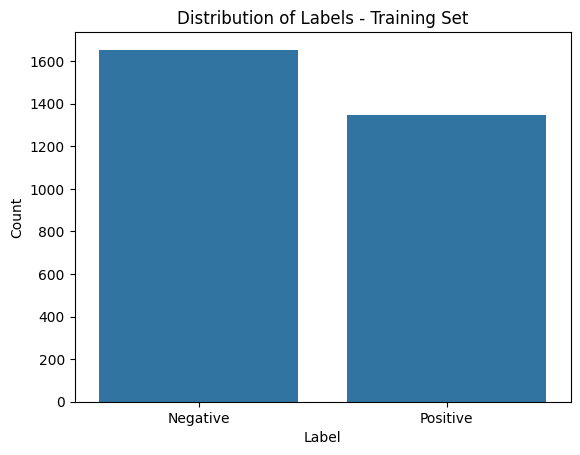

In [65]:
from collections import Counter

# Count the number of observations by class
label_counts = Counter(small_train_dataset['label'])

# Convert the counts to a DataFrame for easy plotting
label_df = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])

# Plotting
sns.barplot(x='Label', y='Count', data=label_df).set_xticklabels(['Negative','Positive'])
plt.title('Distribution of Labels - Training Set')
plt.show()

To [preprocess](https://huggingface.co/docs/transformers/preprocessing#everything-you-always-wanted-to-know-about-padding-and-truncation) our data, we will use [DistilBERT tokenizer](https://huggingface.co/docs/transformers/v4.15.0/en/model_doc/distilbert#transformers.DistilBertTokenizer):


In [13]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Next, we prepare the text inputs for the model for both splits of our dataset (training and test) by using the [map method](https://huggingface.co/docs/datasets/en/process#map) with [batch processing](https://huggingface.co/docs/datasets/en/process#batch-processing):

In [14]:
# Prepare the text inputs for the model
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

if small_data:
    tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
    tokenized_test = small_test_dataset.map(preprocess_function, batched=True)
else:
    tokenized_train = train_data.map(preprocess_function, batched=True)
    tokenized_test = test_data.map(preprocess_function, batched=True)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Sentences aren’t always the same length which can be an issue because the model inputs need to have a uniform shape. Padding is a strategy for ensuring tensors are rectangular by adding a special padding token to shorter sentences. We use a [Data Collator](https://huggingface.co/docs/transformers/en/main_classes/data_collator) to convert our training samples to PyTorch tensors and concatenate them with the correct amount of [padding](https://huggingface.co/docs/transformers/preprocessing#pad):

In [15]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
data_collator

DataCollatorWithPadding(tokenizer=DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}, padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='pt')

### 3. Training the model

For training, we will be using the [Trainer API](https://huggingface.co/docs/transformers/v4.15.0/en/main_classes/trainer#transformers.Trainer), which is optimized for fine-tuning Transformers models such as DistilBERT.

First, we define DistilBERT as our base model:

In [16]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Then, we define the metrics we'll be using to evaluate how good is the fine-tuned model ([accuracy and f1 score](https://huggingface.co/metrics)):

In [17]:
import numpy as np
from datasets import load_metric

def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": accuracy, "f1": f1}

Before training our model, we need to define the training arguments and define a Trainer with all the objects we constructed up to this point:

In [18]:
from transformers import TrainingArguments, Trainer

output_name = data_path + "Output"

training_args = TrainingArguments(
   output_dir=output_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

Now, we train the model on the dataset:

In [19]:
trainer.train()

Step,Training Loss


KeyboardInterrupt: 

Finally, we compute the evaluation metrics to see how good your model is:

In [ ]:
trainer.evaluate()

<ipython-input-17-dcbaed1ca091>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:753: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:753: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'eval_loss': 0.41115686297416687,
 'eval_accuracy': 0.824,
 'eval_f1': 0.8181818181818182,
 'eval_runtime': 16.1086,
 'eval_samples_per_second': 62.079,
 'eval_steps_per_second': 3.911,
 'epoch': 2.0}

### 4. Training Over Different SubReddits

In this section we'll train five additional models based on a subset of subreddits. We will then test how those models perform on the original test data. The reason behind this is that different subreddits have different sentiment, so we are interesting in seeing how biased the model is once it is trained on more positive/negative data

#### 4.1 Data Subset

We'll begin by plotting the average sentiment for each of our categories:

In [20]:
sub_comments = pd.read_csv(data_path + "by_category/comments_filtered.csv", quoting=csv.QUOTE_NONNUMERIC, dtype=dtype_dict)

In [46]:
# Define date
sub_comments['date'] = pd.to_datetime(sub_comments['date'])
sub_comments['year'] = sub_comments['date'].dt.to_period('Y').dt.to_timestamp()
sub_comments['year_month'] = sub_comments['date'].dt.to_period('M').dt.to_timestamp()

In [48]:
# Sentiment by category and year-month
avg_sentiment_cat = sub_comments.groupby(['subreddit.name','year']).agg({'sentiment':'mean'}).reset_index().rename(columns={'sentiment':'avg_sentiment'})

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_facets(df, categories):

    # Calculate global min and max sentiment scores for consistent y-axis limits
    global_min = df['avg_sentiment'].min()
    global_max = df['avg_sentiment'].max()

    # Create the FacetGrid
    g = sns.FacetGrid(df, col='subreddit.name', col_wrap=3, height=4, sharey=False)

    # Map the lineplot
    g.map_dataframe(sns.lineplot, 'year', 'avg_sentiment')

    # Set the same y-axis limits for all plots
    g.set(ylim=(global_min, global_max))

    # Set the titles and labels
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("Year", "Average Sentiment")

    # Rotate x-axis labels and adjust layout
    for ax in g.axes.flatten():
        ax.tick_params(labelbottom=True)
        plt.setp(ax.get_xticklabels(), rotation=45)

    plt.tight_layout()  # Adjust layout to fit all elements
    plt.show()

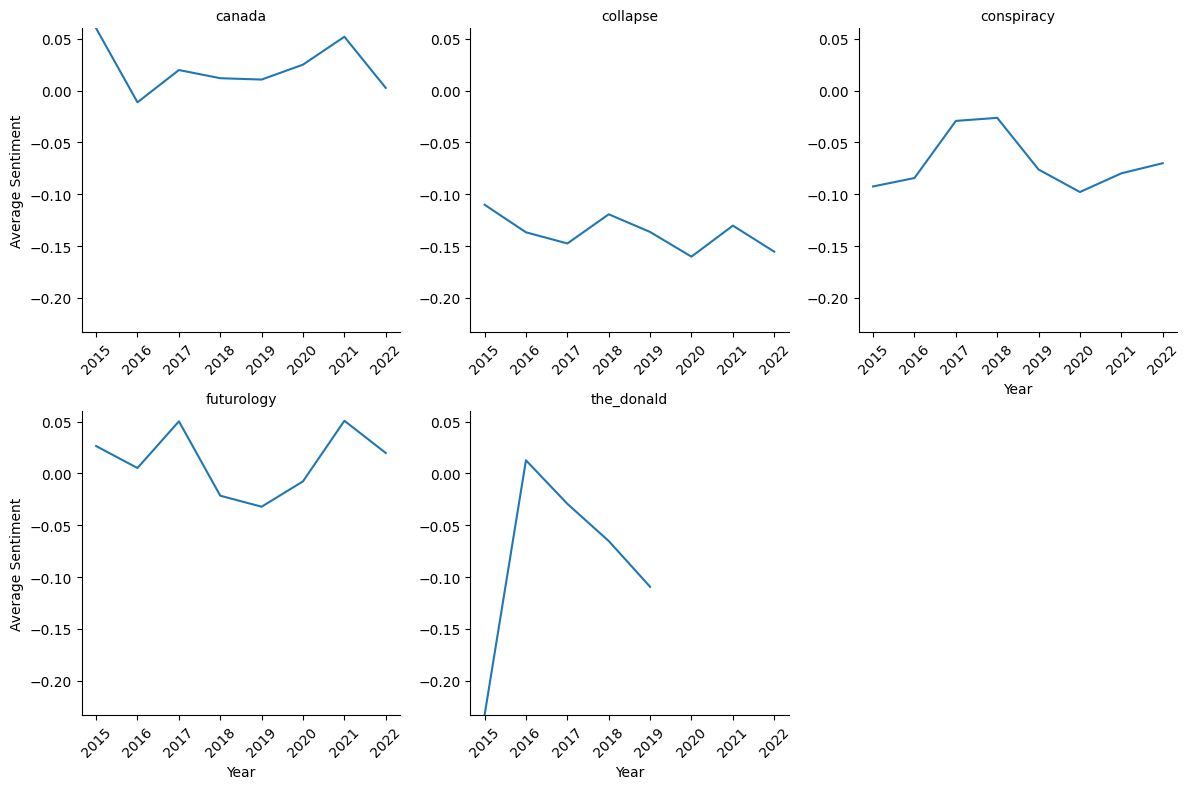

In [54]:
plot_facets(avg_sentiment_cat, avg_sentiment_cat['subreddit.name'].unique())

As we can see from the previous plot, the average sentiment of two out of five categories is somewhat positive, while the others are more negative.

#### 4.2 Pre-processing

We conduct the same steps as before for the pre-processing part for each one of the datasets:

In [73]:
canada_comments.head()

,subreddit.name,date,body,sentiment,label,year_month,year,test_split
1,canada,2022-08-31 23:27:11,"['Pipelines will be blown up,' says David Suzu...",-0.9719,0,2022-08-01,2022-01-01,0
3,canada,2022-08-31 23:14:46,I'm not running from anything.\n\nI haven't ex...,0.7942,1,2022-08-01,2022-01-01,0
9,canada,2022-08-31 22:06:25,&gt;Painting an entire group of people isn’t c...,-0.9858,0,2022-08-01,2022-01-01,0
32,canada,2022-08-31 20:33:20,Do you understand the concept of a market fail...,-0.9717,0,2022-08-01,2022-01-01,0
38,canada,2022-08-31 19:49:38,Christmas day 1997 I was sporting shorts and a...,-0.8316,0,2022-08-01,2022-01-01,0


In [79]:
canada_comments = sub_comments[sub_comments['subreddit.name']=='canada'].reset_index(drop=True)
collapse_comments = sub_comments[sub_comments['subreddit.name']=='collapse'].reset_index(drop=True)
conspiracy_comments = sub_comments[sub_comments['subreddit.name']=='conspiracy'].reset_index(drop=True)
futurology_comments = sub_comments[sub_comments['subreddit.name']=='futurology'].reset_index(drop=True)
donald_comments = sub_comments[sub_comments['subreddit.name']=='the_donald'].reset_index(drop=True)

In [80]:
# Obtain train split for each dataset
canada_train, _ = train_test_split(canada_comments, 0.2)
collapse_train, _ = train_test_split(collapse_comments, 0.2)
conspiracy_train, _ = train_test_split(conspiracy_comments, 0.2)
futurology_train, _ = train_test_split(futurology_comments, 0.2)
donald_train, _ = train_test_split(donald_comments, 0.2)

In [81]:
# Create a smaller training dataset for faster training times
small_canada_train = canada_train.shuffle(seed=42).select([i for i in list(range(train_obs))])
small_collapse_train = collapse_train.shuffle(seed=42).select([i for i in list(range(train_obs))])
small_conspiracy_train = conspiracy_train.shuffle(seed=42).select([i for i in list(range(train_obs))])
small_futurology_train = futurology_train.shuffle(seed=42).select([i for i in list(range(train_obs))])
small_donald_train = donald_train.shuffle(seed=42).select([i for i in list(range(train_obs))])

In [83]:
canada_tokenized = small_canada_train.map(preprocess_function, batched=True)
collase_tokenized = small_collapse_train.map(preprocess_function, batched=True)
conspiracy_tokenized = small_conspiracy_train.map(preprocess_function, batched=True)
futurology_tokenized = small_futurology_train.map(preprocess_function, batched=True)
donald_tokenized = small_donald_train.map(preprocess_function, batched=True)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

#### 4.3 Testing the models

##### a. `canada` subreddit:

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

In [ ]:
canada_trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=canada_tokenized,
   eval_dataset=tokenized_test, # Leave the original one
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
canada_trainer.train()

In [ ]:
canada_trainer.evaluate()

In [ ]:
canada_trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=canada_tokenized,
   eval_dataset=tokenized_test, # Leave the original one
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

##### b. `collapse` subreddit:

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

In [ ]:
collapse_trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=collase_tokenized,
   eval_dataset=tokenized_test, # Leave the original one
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
collapse_trainer.train()

In [ ]:
collapse_trainer.evaluate()

##### c. `conspiracy` subreddit:

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

In [ ]:
conspiracy_trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=conspiracy_tokenized,
   eval_dataset=tokenized_test, # Leave the original one
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
conspiracy_trainer.train()

In [ ]:
conspiracy_trainer.evaluate()

##### d. `futurology` subreddit:

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

In [ ]:
futurology_trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=futurology_tokenized,
   eval_dataset=tokenized_test, # Leave the original one
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
futurology_trainer.train()

In [ ]:
futurology_trainer.evaluate()

##### e. `the_donald` subreddit:

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

In [ ]:
donald_trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=donald_tokenized,
   eval_dataset=tokenized_test, # Leave the original one
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
donald_trainer.train()

In [ ]:
donald_trainer.evaluate()